In [403]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from sys import getsizeof
%load_ext line_profiler
from numba import njit

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [920]:
#Gates

I = np.eye(2)
H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
 
def P(phi):
    #Phase gate
    return np.exp(1j*phi)*np.eye(2)

def Rx(theta):
    return expm(-1j*X*theta/2)

def Rz(theta):
    return expm(-1j*Z*theta/2)

def Ry(theta):
    return expm(-1j*Y*theta/2)


alphabet = "abcdefghijklmnopqrstuvwxyz"

def Multi_gate(gate, k : int, n : int, method = 'kron'):
        """
        gate: Single_qubit_gate()
        k: gate qubit index
        n: total number of qubits
        """
        lst = [np.eye(2) if j != k else gate for j in range(n)]
        #Make the einstring for the tensor product of n tensors
        if method == 'kron':
            return ft.reduce(np.kron, lst) #Optimise this
        elif method == 'einsum':
            
            t = iter(alphabet[0:int(2*n)])
            einstring = ','.join(a+b for a,b in zip(t, t))
            x = alphabet[0:2*n][0::2]
            y = alphabet[0:2*n][1::2]
            return np.einsum(einstring+'->'+x+y,*lst) 
            #So that output has same index convension as ft.reduct(np.kron, list).reshape((2,2,...,2,2,...))
    
def Multi_CNOT(k1 : int, k2 : int, n : int, method ='kron'):
    """
    k1: control qubit index
    k2: target qubit index
    n: total number of qubits
    """
    cnot0 = np.array([[1,0],[0,0]])
    cnot1 = np.array([[0,0],[0,1]])
    cnotx = np.array([[0,1],[1,0]])
    
    lst1 = [np.eye(2) if j != k1 else cnot0  for j in range(n)]
    lst2 = [cnot1 if j == k1 else cnotx if j == k2 else np.eye(2) for j in range(n) ]

    if method == 'kron':
        return ft.reduce(np.kron,lst1) + ft.reduce(np.kron,lst2) #Optimise this 

    elif method == 'einsum':
    
        #Make the einstring for the tensor product of n tensors
        t = iter(alphabet[0:int(2*n)])
        einstring = ','.join(a+b for a,b in zip(t, t))
        x = alphabet[0:2*n][0::2]
        y = alphabet[0:2*n][1::2]
        return np.einsum(einstring+'->'+x+y,*lst1) +np.einsum(einstring+'->'+x+y,*lst2) 
        #So that output has same index convension as ft.reduct(np.kron, list).reshape((2,2,...,2,2,...))

    

#State class 
class State:
    def __init__(self, num_qubits :int, init_state = 0):
        """
        init_state: index of basis vector of the initial state
        """
        self.num_qubits = num_qubits
        self.basis = list(it.product(range(2), repeat=num_qubits))
        
        #Initialise the state in init_state
        self.tensor = np.zeros([2 for i in range(num_qubits)],dtype=complex)
        self.tdim = self.tensor.shape
        self.tdim_flat = 2**self.num_qubits
        self.tensor[self.basis[init_state]] = 1
        #self.einidx = alphabet[0:2*self.num_qubits]

        #t = iter(self.einidx)
        #self.einstr = ','.join(a+b for a,b in zip(t, t))

    def apply_single_qubit_gate(self, gate, k :int, method = 'kron'):
        
        multigate = Multi_gate(gate, k, self.num_qubits, method)
            
        if method == 'einsum':
            multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))
        
        self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

    def apply_cnot_qubit_gate(self, k1 : int, k2 : int, method = 'kron'):
        multigate = Multi_CNOT(k1,k2, self.num_qubits, method)
        if method =='einsum':
            
            multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))

        self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)


    def conditional_measurement(self, k : int, proj: int):
        """
        k: qubit being measured
        proj: 0 or 1, state of projection
        
        """
        
        #Swap indices so k is the last qubit
        swapped = self.tensor.swapaxes(k, -1)
        self.tensor = swapped[..., proj] #Project last qubit into 0 or 1 state 

        #Calculate the probability
        norm  = np.sum(np.abs(self.tensor))**2
        if norm != 0:
            self.tensor /= norm #Normalise the tensor
        else:
            print(f'Probability of qubit {k} being {proj} is {norm}.')

        #Update properties of reduced state
        self.num_qubits = len(self.tensor)
        self.basis = list(it.product(range(2), repeat=self.num_qubits))
        self.tdim = self.tensor.shape
        self.tdim_flat = 2**self.num_qubits

    def plot_state(self):
        """
        Plot the probability of each basis vector
        """
        probs = np.abs(self.tensor)**2
                    
        plt.bar(range(self.tdim_flat), probs.reshape(self.tdim_flat))
        #plt.bar(range(num_basis_states) ,self.probabilities)

        labels = self.basis

        
        if self.num_qubits <= 4:
            plt.xticks(np.arange(2**self.num_qubits),self.basis, rotation = 90)
            plt.xlabel('Basis state')
        else:
            plt.xlabel('Basis number')
            
        plt.ylabel('Probability')
    

        
       

## Initialise the $\ket{000}$ state

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


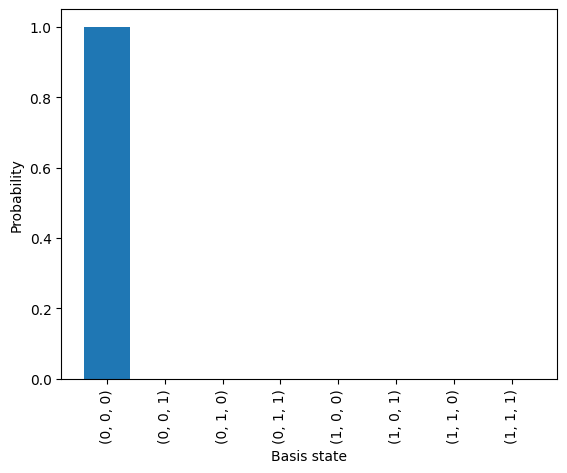

In [848]:
state = State(3)
print(state.basis)
state.plot_state()



## Apply some single mode gates 
(I always initialise the $\ket{000}$ state)

(2, 2, 2)


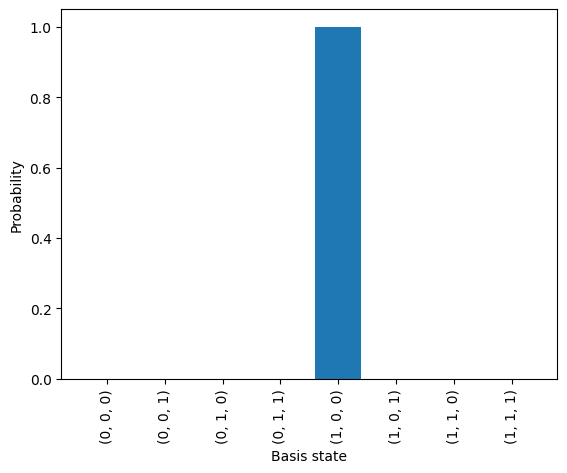

In [849]:
## Apply an X gate 
num = 3
state = State(num)
state.apply_single_qubit_gate(X, 0)
print(state.tensor.shape)
state.plot_state()


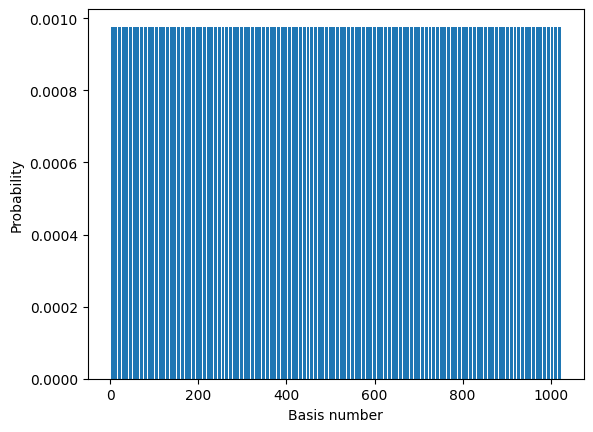

In [850]:
## Apply Hadamard gate on all qubits

num = 10

state = State(num, )

[state.apply_single_qubit_gate(H, i) for i in range(0,num)]
#state.apply_single_qubit_gate(Y_gate, 2)

state.plot_state()


## Initialise state $\ket{100}$

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


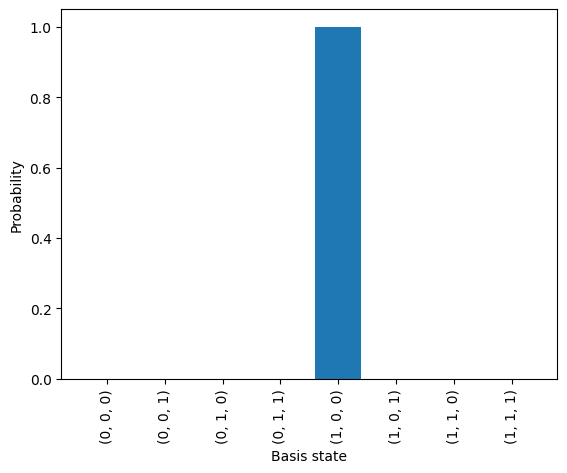

In [851]:
state = State(3, 4) #Initialise state in #100 
print(state.basis)
state.plot_state()

## Comparing the performance of `np.kron` and `np.einsum` for creating the multiqubit gate tensor

In [912]:
times_kron = np.zeros(10)
times_einsum = np.zeros(10)
for i, num in enumerate(range(1,10+1)):
    print(f'nqubits = {num}')
    state = State(num)
    var1 = %timeit -o state.apply_single_qubit_gate(H, 0)
    times_kron[i] = var1.average
    state = State(num)
    var2 = %timeit -o state.apply_single_qubit_gate(H, 0,'einsum')
    times_einsum[i] = var2.average
    

nqubits = 1
1.62 μs ± 277 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.82 μs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 2
10.3 μs ± 62.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.51 μs ± 26.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 3
19 μs ± 148 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.29 μs ± 44.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 4
28.8 μs ± 282 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.56 μs ± 46.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 5
41.9 μs ± 326 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20.6 μs ± 89 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
nqubits = 6
138 μs ± 11.6 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
122 μs ± 1.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
nqubits = 7
302 μs ± 96.2 μs per 

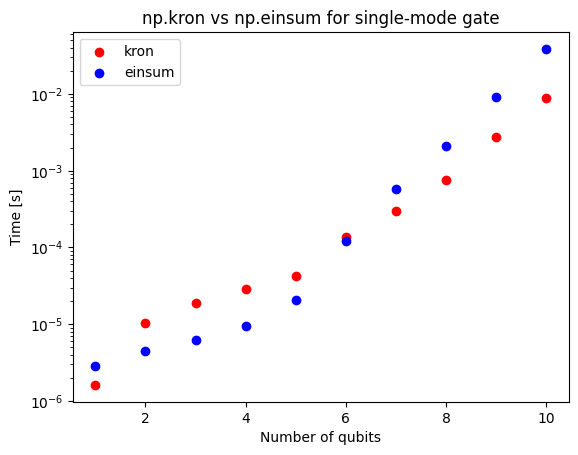

In [918]:
plt.scatter(range(1,11), times_kron, color = 'r', label = 'kron')
plt.scatter(range(1,11), times_einsum, color ='b',label = 'einsum')
plt.yscale('log')
plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.legend()
plt.title('np.kron vs np.einsum for single-mode gate')
plt.show()

In [921]:
times_kron = np.zeros(10)
times_einsum = np.zeros(10)
for i, num in enumerate(range(1,10+1)):
    print(f'nqubits = {num}')
    state = State(num)
    
    var1 = %timeit -o state.apply_cnot_qubit_gate(0,1)
    times_kron[i] = var1.average
    state = State(num)
    var2 = %timeit -o state.apply_cnot_qubit_gate(0,1,'einsum')
    times_einsum[i] = var2.average

nqubits = 1
3.61 μs ± 52.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.58 μs ± 51.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 2
21.1 μs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
8.95 μs ± 82.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 3
38.3 μs ± 619 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
11.4 μs ± 79.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 4
60 μs ± 528 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
18.4 μs ± 76.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
nqubits = 5
83 μs ± 678 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
39.5 μs ± 463 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
nqubits = 6
319 μs ± 36.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
312 μs ± 67.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
nqubits = 7
592 μs ± 49.3 μs per loo

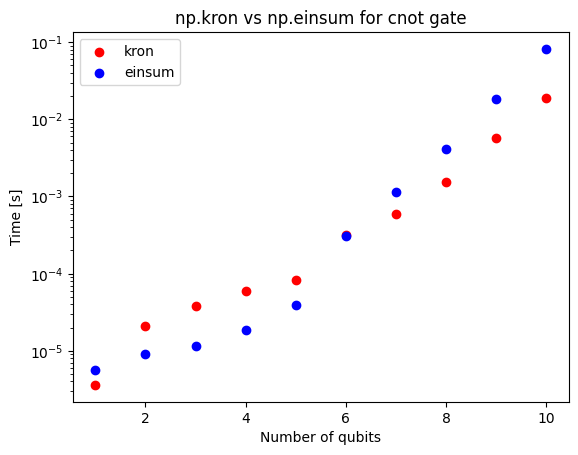

In [922]:
plt.scatter(range(1,11), times_kron, color = 'r', label = 'kron')
plt.scatter(range(1,11), times_einsum, color ='b',label = 'einsum')
plt.yscale('log')
plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.legend()
plt.title('np.kron vs np.einsum for cnot gate')
plt.show()

In [933]:
num = 3
state = State(num)
%lprun -f state.apply_single_qubit_gate state.apply_single_qubit_gate(H, 0, method = 'kron')

Timer unit: 1e-09 s

Total time: 0.000458 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/3489868588.py
Function: apply_single_qubit_gate at line 91

Line #      Hits         Time  Per Hit   % Time  Line Contents
    91                                               def apply_single_qubit_gate(self, gate, k :int, method = 'kron'):
    92                                                   
    93         1     420000.0 420000.0     91.7          multigate = Multi_gate(gate, k, self.num_qubits, method)
    94                                                       
    95         1          0.0      0.0      0.0          if method == 'einsum':
    96                                                       multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))
    97                                                   
    98         1      38000.0  38000.0      8.3          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

In [934]:
num = 3
state = State(num)
%lprun -f state.apply_single_qubit_gate state.apply_single_qubit_gate(H, 0, method = 'einsum')

Timer unit: 1e-09 s

Total time: 0.000224 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/3489868588.py
Function: apply_single_qubit_gate at line 91

Line #      Hits         Time  Per Hit   % Time  Line Contents
    91                                               def apply_single_qubit_gate(self, gate, k :int, method = 'kron'):
    92                                                   
    93         1     164000.0 164000.0     73.2          multigate = Multi_gate(gate, k, self.num_qubits, method)
    94                                                       
    95         1       1000.0   1000.0      0.4          if method == 'einsum':
    96         1       6000.0   6000.0      2.7              multigate = multigate.reshape((self.tdim_flat, self.tdim_flat))
    97                                                   
    98         1      53000.0  53000.0     23.7          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

## Profiling `Multi_CNOT`

In [935]:
%prun Multi_CNOT(0, 2, 10)

         1339 function calls in 0.031 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.026    0.001    0.027    0.002 shape_base.py:1067(kron)
        1    0.002    0.002    0.030    0.030 3489868588.py:44(Multi_CNOT)
       72    0.000    0.000    0.001    0.000 shape_base.py:512(expand_dims)
       72    0.000    0.000    0.000    0.000 numeric.py:1330(normalize_axis_tuple)
        2    0.000    0.000    0.028    0.014 {built-in method _functools.reduce}
        1    0.000    0.000    0.030    0.030 <string>:1(<module>)
       90    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
       72    0.000    0.000    0.000    0.000 shape_base.py:600(<listcomp>)
       17    0.000    0.000    0.000    0.000 twodim_base.py:158(eye)
        1    0.000    0.000    0.031    0.031 {built-in method builtins.exec}
       72    0.000    0.000    0.000    0.000 numeric.py:1380(<listcomp>)
     

In [936]:
%prun Multi_CNOT(0, 2, 10, 'einsum')

         120 function calls in 0.091 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.090    0.045    0.090    0.045 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.001    0.001    0.091    0.091 3489868588.py:44(Multi_CNOT)
        1    0.000    0.000    0.091    0.091 <string>:1(<module>)
       17    0.000    0.000    0.000    0.000 twodim_base.py:158(eye)
        1    0.000    0.000    0.091    0.091 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method numpy.array}
       17    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 3489868588.py:54(<listcomp>)
        1    0.000    0.000    0.000    0.000 3489868588.py:55(<listcomp>)
       11    0.000    0.000    0.000    0.000 3489868588.py:64(<genexpr>)
        1    0.000    0.000    0.000    0.000 {method 'join' of 'str' objects}
     

## Measure a qubit

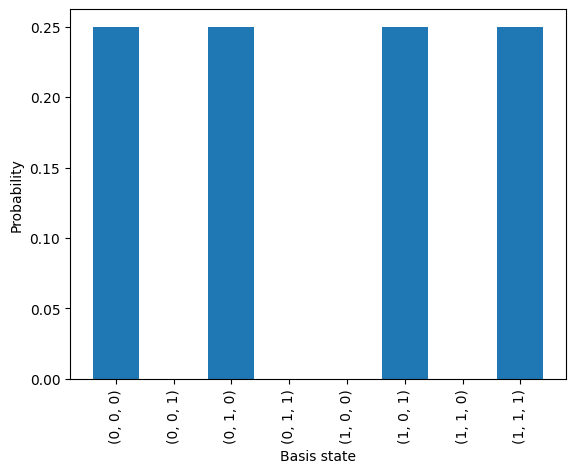

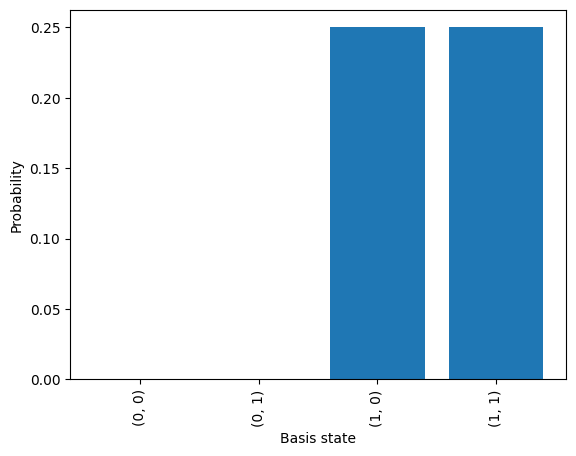

In [727]:
#Initial state
state = State(3)
state.apply_single_qubit_gate(H, 0)
state.apply_single_qubit_gate(H, 1)
state.apply_cnot_qubit_gate(0,2)
state.plot_state()
plt.show()


#Measure mode 0 to be 1
state.conditional_measurement(2,1)
state.plot_state()
